In [1]:
# !pip install noisereduce
# pip install resampy

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import librosa
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
import noisereduce as nr


In [3]:
celltypes = ['artifact', 'extrahls', 'extrastole', 'murmur', 'normal']
path = ["C:/Users/Ayzah/Documents/University/CS354 - Deep Learning/Project/Heartbeat_Sound" + "/" + celltype for celltype in celltypes]
path

['C:/Users/Ayzah/Documents/University/CS354 - Deep Learning/Project/Heartbeat_Sound/artifact',
 'C:/Users/Ayzah/Documents/University/CS354 - Deep Learning/Project/Heartbeat_Sound/extrahls',
 'C:/Users/Ayzah/Documents/University/CS354 - Deep Learning/Project/Heartbeat_Sound/extrastole',
 'C:/Users/Ayzah/Documents/University/CS354 - Deep Learning/Project/Heartbeat_Sound/murmur',
 'C:/Users/Ayzah/Documents/University/CS354 - Deep Learning/Project/Heartbeat_Sound/normal']

In [4]:
def features_extractor(filename):
    audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') #load an audio file, res_type='kaiser_fast' is used for resampling (for consistency)
    reduced_noise = nr.reduce_noise(y=audio, sr=sample_rate)
    # MFCC (Mel-Frequency Cepstral Coefficients) are used for audio processing
    mfccs_features = librosa.feature.mfcc(y=reduced_noise, sr=sample_rate, n_mfcc=25) # 25 MFCCs are being returned for potentially richer feature representation
    return mfccs_features.T  # transpose to get shape: timesteps, 25

In [5]:
import resampy # not being used directly, feature extraction was having some issues, importing this resolved those

In [6]:
extracted_features = []
for index, values in enumerate(path):
    file_names = os.listdir(values)
    for i in range(len(file_names)):
        final_class_labels = celltypes[index] # class label assignment
        # feature extraction
        data = features_extractor("C:/Users/Ayzah/Documents/University/CS354 - Deep Learning/Project/Heartbeat_Sound" + "/" + final_class_labels + "/" + file_names[i])
        extracted_features.append([data, final_class_labels])

In [7]:
# convert extracted_features to dataframe
extracted_features_df = pd.DataFrame(extracted_features, columns=['feature', 'class'])
extracted_features_df.tail()
extracted_features_df["class"].value_counts()

class
normal        351
murmur        129
extrastole     46
artifact       40
extrahls       19
Name: count, dtype: int64

In [24]:
# initialize dictionaries for features and class
features_by_class = {celltype: [] for celltype in celltypes}

# extract features
for index, values in enumerate(path):
    file_names = os.listdir(values)
    for file_name in file_names:
        final_class_labels = celltypes[index]
        data = features_extractor(os.path.join(values, file_name))
        features_by_class[final_class_labels].append(data)

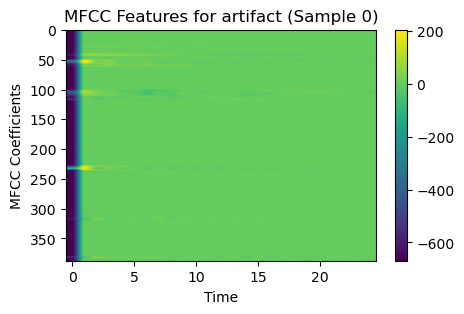

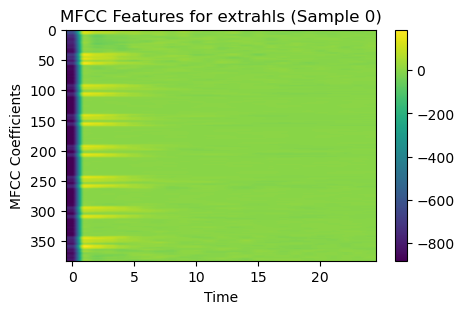

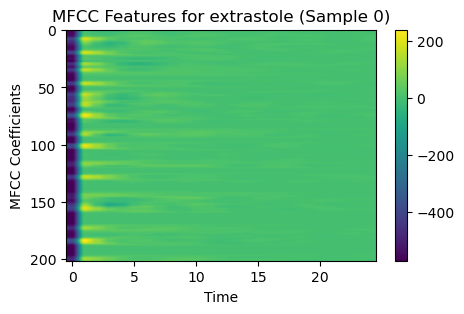

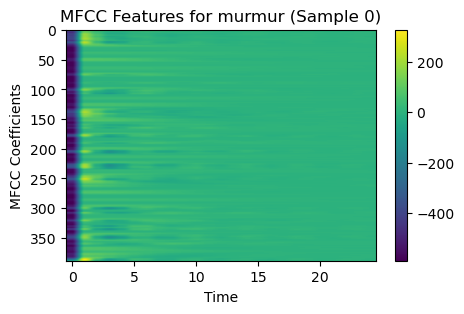

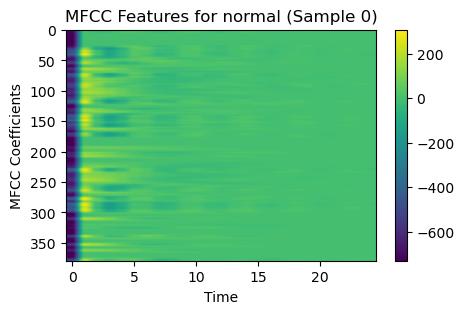

In [26]:
def plot_features(features, class_name, sample_index=0):
    plt.figure(figsize=(5, 3))
    plt.imshow(features[sample_index], cmap='viridis', aspect='auto')
    plt.title(f'MFCC Features for {class_name} (Sample {sample_index})')
    plt.xlabel('Time')
    plt.ylabel('MFCC Coefficients')
    plt.colorbar()
    plt.show()

for class_name, features in features_by_class.items():
    if features:
        plot_features(features, class_name, sample_index=0)


In [8]:
# split and pad the dataset into independent and dependent dataset
from keras.preprocessing.sequence import pad_sequences

# converting feature column into a list of arrays
X = pad_sequences(extracted_features_df['feature'].tolist(), 
                  maxlen=585, padding='post', dtype='float32')
# converting class column into a list of arrays
y = np.array(extracted_features_df['class'].tolist())

In [9]:
X.shape

(585, 585, 25)

In [10]:
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [31]:
y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [11]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=0)

In [12]:
num_labels=6

In [13]:
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional, Flatten, Conv1D, MaxPool1D, BatchNormalization

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization, SimpleRNN
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

model = Sequential()

# Conv1D, max pooling, batch normalization
model.add(Conv1D(filters=32, kernel_size=9, activation='relu', input_shape=(585, 25)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4, strides=4))

model.add(Conv1D(filters=64, kernel_size=9, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4, strides=4))

model.add(Conv1D(filters=128, kernel_size=9, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4, strides=4))

# LSTM
# model.add(LSTM(64, return_sequences=True))
# model.add(Dropout(0.4))

# SimpleRNN
# model.add(SimpleRNN(64, return_sequences=False))
# model.add(Dropout(0.4))

# flatten the output from Conv layers because the  
# result is now in 3D while Dense layers require 2D
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))  # increased the dropout rate to avoid overfitting
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))

# output layer
model.add(Dense(5, activation='softmax'))


# set the learning rate smaller to improve accuracy
model.compile(loss='categorical_crossentropy', optimizer=Adam(1e-5), metrics=['acc'])


print(model.summary())


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 577, 32)           7232      
                                                                 
 batch_normalization_3 (Bat  (None, 577, 32)           128       
 chNormalization)                                                
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 144, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 136, 64)           18496     
                                                                 
 batch_normalization_4 (Bat  (None, 136, 64)           256       
 chNormalization)                                                
                                                      

In [19]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Patience is a parameter of the early stopping mechanism that specifies how many epochs the
# training process will continue after the last improvement in the monitored metric before stopping.

epochscount = 150
num_batch_size = 15

history = model.fit(
    X, y,
    batch_size=num_batch_size,
    epochs=epochscount,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/150
32/32 [==============================] - 3s 25ms/step - loss: 2.0132 - acc: 0.2543 - val_loss: 1.4381 - val_acc: 0.1111
Epoch 2/150
32/32 [==============================] - 1s 16ms/step - loss: 1.8447 - acc: 0.2628 - val_loss: 1.4327 - val_acc: 0.1966
Epoch 3/150
32/32 [==============================] - 0s 16ms/step - loss: 1.7414 - acc: 0.2821 - val_loss: 1.4011 - val_acc: 0.3419
Epoch 4/150
32/32 [==============================] - 1s 16ms/step - loss: 1.7270 - acc: 0.2821 - val_loss: 1.3648 - val_acc: 0.4017
Epoch 5/150
32/32 [==============================] - 1s 18ms/step - loss: 1.6327 - acc: 0.3226 - val_loss: 1.3225 - val_acc: 0.4444
Epoch 6/150
32/32 [==============================] - 1s 27ms/step - loss: 1.6160 - acc: 0.3355 - val_loss: 1.2823 - val_acc: 0.5043
Epoch 7/150
32/32 [==============================] - 1s 32ms/step - loss: 1.5579 - acc: 0.4060 - val_loss: 1.2413 - val_acc: 0.5641
Epoch 8/150
32/32 [==============================] - 1s 29ms/step - loss: 1.

32/32 [==============================] - 1s 30ms/step - loss: 1.0793 - acc: 0.5833 - val_loss: 0.8715 - val_acc: 0.7949
Epoch 63/150
32/32 [==============================] - 1s 30ms/step - loss: 1.0875 - acc: 0.5812 - val_loss: 0.8673 - val_acc: 0.7949
Epoch 64/150
32/32 [==============================] - 1s 31ms/step - loss: 1.0499 - acc: 0.6026 - val_loss: 0.8634 - val_acc: 0.7949
Epoch 65/150
32/32 [==============================] - 1s 29ms/step - loss: 1.0989 - acc: 0.5769 - val_loss: 0.8664 - val_acc: 0.7949
Epoch 66/150
32/32 [==============================] - 1s 28ms/step - loss: 1.0909 - acc: 0.5940 - val_loss: 0.8680 - val_acc: 0.7949
Epoch 67/150
32/32 [==============================] - 1s 32ms/step - loss: 1.0412 - acc: 0.6047 - val_loss: 0.8660 - val_acc: 0.8034
Epoch 68/150
32/32 [==============================] - 1s 30ms/step - loss: 1.0932 - acc: 0.5748 - val_loss: 0.8699 - val_acc: 0.7863
Epoch 69/150
32/32 [==============================] - 1s 33ms/step - loss: 1.0508 

In [20]:
validation_test_set_accuracy = model.evaluate(X_test,y_test,verbose=0)
print(validation_test_set_accuracy[1])

0.7288135886192322


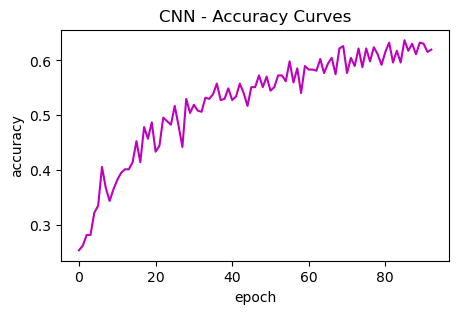

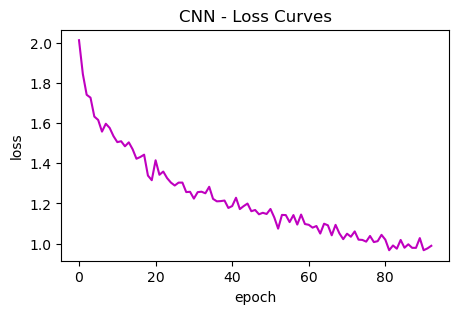

In [30]:
accuracy = history.history['acc']
loss = history.history['loss']

plt.figure(1, figsize=(5, 3))
plt.title('CNN - Accuracy Curves')
plt.plot(accuracy, c='m')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.figure(2, figsize=(5, 3))
plt.title('CNN - Loss Curves')
plt.plot(loss, c='m')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

In [21]:
from sklearn.metrics import classification_report, accuracy_score


# get predicted probabilities
y_pred_prob = model.predict(X_test)

# get class with highest probability
y_pred = np.argmax(y_pred_prob, axis=1)

# conver one-hot encoded y_test back to class indices
y_true = np.argmax(y_test, axis=1)

# map numerical predictions to cell type labels
y_pred_labels = [celltypes[i] for i in y_pred]
y_true_labels = [celltypes[i] for i in y_true]

print(f"Predicted labels: {y_pred_labels[:10]}")
print(f"True labels: {y_true_labels[:10]}")

# evaluate model
accuracy = accuracy_score(y_true_labels, y_pred_labels)
print(f"Accuracy: {accuracy:.4f}")


2/2 [==============================] - 0s 12ms/step
Predicted labels: ['normal', 'normal', 'normal', 'murmur', 'normal', 'normal', 'murmur', 'artifact', 'murmur', 'normal']
True labels: ['normal', 'extrastole', 'normal', 'murmur', 'normal', 'extrastole', 'normal', 'artifact', 'extrahls', 'normal']
Accuracy: 0.7288
